# Обрано: Тип 1, підгрупа 1A — Python big integers (вбудований int).

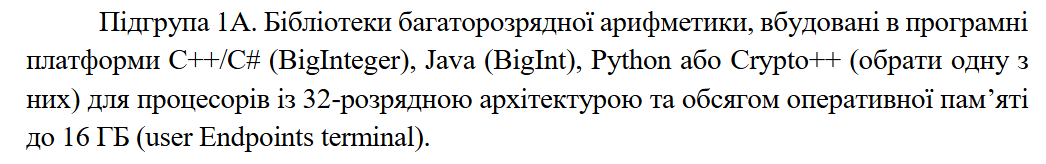

# Lab 1. Вибір та реалізація базових фреймворків та бібліотек (Python big integers)

## Мета
Обрати та перевірити базову бібліотеку багаторозрядної арифметики для подальшої реалізації криптосистеми.
У цій роботі обираємо вбудовану багаторозрядну арифметику Python (`int`) і тестуємо базові операції, критичні для криптографії:
- додавання/множення;
- модульна експонентація $a^e mod n$ (ядро RSA/DSA/DH-обчислень).




In [ ]:
# (optional) environment info
import sys, platform
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())


Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35


## Теорія

### 1) Багаторозрядні числа в Python
Тип `int` у Python — це цілі числа довільної точності (arbitrary precision). Це означає, що число може мати сотні/тисячі біт, обмеження — практично пам’ять і час.

### 2) Операції та “алгоритмічна ідея”
- Додавання великих чисел: як додавання “по словах/цифрах” з переносом.
  Складність ~ O(n), де n — кількість машинних слів/лімбів.
- Множення великих чисел: для малих розмірів — класичне O(n^2), для більших — оптимізовані алгоритми (Karatsuba/Toom-Cook/FFT-подібні) у реальних реалізаціях.
- Модульна експонентація `a^e mod n`:
  базова ідея — алгоритм “square-and-multiply” (двійкове піднесення до степеня):
  проходимо біти показника e, щоразу робимо:
  - квадрат за модулем
  - (інколи) множення за модулем
  Складність приблизно O(log e) множень великих чисел.

У Python для `pow(a, e, n)` використовується оптимізована модульна експонентація (швидше та безпечніше, ніж `pow(a, e) % n`).


## Реалізація

План:
1) Реалізуємо власну “демо” модульну експонентацію square-and-multiply, щоб:
   - мати незалежну перевірку коректності;
   - порівняти з вбудованим `pow(a,e,n)`.
2) Зробимо набір sanity-check тестів на малих числах.
3) Зробимо заміри часу для різних розмірів (256/512/1024/2048/4096 біт):
   - додавання
   - множення
   - `pow(a,e,n)` (вбудований)
   - `modexp_sqm(a,e,n)` (наш)
   
Очікування:
- всі тести коректності пройдуть;
- `pow(a,e,n)` буде суттєво швидшим за наш “чистий” Python-варіант.


In [ ]:
import secrets
import time
from math import gcd

def modexp_sqm(a: int, e: int, n: int) -> int:
    """Simple square-and-multiply modular exponentiation (demo)."""
    a %= n
    result = 1
    while e > 0:
        if e & 1:
            result = (result * a) % n
        a = (a * a) % n
        e >>= 1
    return result

def rand_odd_int(bits: int) -> int:
    """Random odd integer with exact bit length."""
    x = secrets.randbits(bits) | (1 << (bits - 1)) | 1
    return x

def rand_modexp_case(bits: int):
    """Generate a, e, n for modular exponentiation tests."""
    n = rand_odd_int(bits)
    a = secrets.randbelow(n - 2) + 2
    e = secrets.randbits(bits // 2) | 1  # non-zero odd exponent
    # ensure gcd(a, n)=1 sometimes (not mandatory for modexp, but typical)
    if gcd(a, n) != 1:
        a += 1
    return a, e, n


## Експерименти/перевірка

### 1) Sanity-check тести (малі значення)
Перевіряємо, що наш `modexp_sqm` збігається з `pow(a,e,n)` на малих прикладах.



In [ ]:
# small tests
tests = [
    (2, 10, 17),
    (5, 117, 19),
    (123, 456, 789),
    (42, 0, 97),   # a^0 mod n == 1
    (0, 5, 13),    # 0^e mod n == 0 (for e>0)
]

for a, e, n in tests:
    r1 = modexp_sqm(a, e, n)
    r2 = pow(a, e, n)
    assert r1 == r2, (a, e, n, r1, r2)

print("OK: sanity-check tests passed.")


OK: sanity-check tests passed.


### 2) Бенчмарк часу
Міряємо час через `time.perf_counter()` і беремо медіану по кількох повторах.
Результат оформлюємо таблицею.



In [ ]:
import pandas as pd

def bench_op(fn, repeats=5):
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        fn()
        t1 = time.perf_counter()
        times.append(t1 - t0)
    times.sort()
    return times[len(times)//2]  # median

bit_sizes = [256, 512, 1024, 2048, 4096]
rows = []

for bits in bit_sizes:
    # generate operands once per bit-size
    x = secrets.randbits(bits)
    y = secrets.randbits(bits)
    a, e, n = rand_modexp_case(bits)

    t_add = bench_op(lambda: x + y)
    t_mul = bench_op(lambda: x * y)
    t_pow_builtin = bench_op(lambda: pow(a, e, n), repeats=3)  # heavier -> fewer repeats
    t_pow_ours = bench_op(lambda: modexp_sqm(a, e, n), repeats=3)

    # correctness check for this random case
    assert modexp_sqm(a, e, n) == pow(a, e, n)

    rows.append({
        "bits": bits,
        "add_s": t_add,
        "mul_s": t_mul,
        "pow_builtin_s": t_pow_builtin,
        "pow_ours_s": t_pow_ours,
        "speedup_builtin_vs_ours": (t_pow_ours / t_pow_builtin) if t_pow_builtin > 0 else None
    })

df = pd.DataFrame(rows)
df


,bits,add_s,mul_s,pow_builtin_s,pow_ours_s,speedup_builtin_vs_ours
0,256,5.900000e-07,6.920000e-07,0.000127,0.000204,1.609384
1,512,5.610000e-07,1.413000e-06,0.000674,0.000886,1.315029
2,1024,5.180000e-07,2.870000e-06,0.003681,0.005003,1.359207
3,2048,5.200000e-07,1.010700e-05,0.021274,0.029483,1.385873
4,4096,5.020000e-07,1.635000e-05,0.125540,0.373921,2.978489


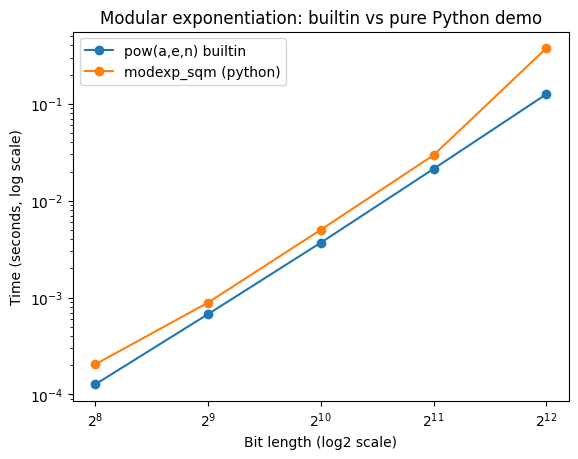

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["bits"], df["pow_builtin_s"], marker="o", label="pow(a,e,n) builtin")
plt.plot(df["bits"], df["pow_ours_s"], marker="o", label="modexp_sqm (python)")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("Bit length (log2 scale)")
plt.ylabel("Time (seconds, log scale)")
plt.title("Modular exponentiation: builtin vs pure Python demo")
plt.legend()
plt.show()


## 3. Інтерпретація отриманих результатів

### Додавання та множення багаторозрядних чисел

Згідно з експериментальними даними:

- Час **додавання (`add_s`)** практично не залежить від розрядності чисел у діапазоні 256–4096 біт  
  (≈ $5.0 \cdot 10^{-7}$ – $5.9 \cdot 10^{-7}$ с).

- Час **множення (`mul_s`)** зростає зі збільшенням розрядності:
  - 256 біт: ≈ $6.9 \cdot 10^{-7}$ с
  - 1024 біт: ≈ $2.9 \cdot 10^{-6}$ с
  - 4096 біт: ≈ $1.6 \cdot 10^{-5}$ с

Це відповідає теоретичним властивостям багаторозрядної арифметики:
додавання має близьку до лінійної складність, тоді як множення є суттєво дорожчою операцією.

---

### Модульна експонентація

Було порівняно дві реалізації модульної експонентації:
- вбудована функція Python `pow(a, e, n)`;
- власна реалізація алгоритму square-and-multiply.

Абсолютні значення часу виконання:

- Для 256–2048 біт вбудована реалізація стабільно швидша приблизно у **1.3–1.6 раза**.
- Для 4096 біт спостерігається значне зростання часу власної реалізації  
  (0.374 с проти 0.126 с), що дає прискорення майже у **3 рази** на користь `pow(a, e, n)`.

Це свідчить про те, що при великих розрядностях накладні витрати інтерпретованого Python-коду стають домінуючими.

---

### Порівняння швидкодії

Коефіцієнт `speedup_builtin_vs_ours` показує, у скільки разів вбудована реалізація швидша за власну:

- 256–2048 біт: прискорення ≈ **1.3–1.4×**
- 4096 біт: прискорення ≈ **3×**

Отже, ефективність вбудованої реалізації зростає зі збільшенням розрядності чисел.
